# Import modules

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
import re
import seaborn as sns

# Provide Path for csv file

In [2]:
project_plan = 'Sample.csv'

# Import and Clean Data

In [3]:
#Import CSV
df =pd.read_csv(project_plan).applymap(lambda s: s.upper() if type(s) == str else s).fillna('0%')
df.keys()

Index(['Task ID', 'Task', 'Resource', 'Workstream', 'Start', 'End',
       'Completion'],
      dtype='object')

In [4]:
# Function to zero-pad the numeric part
def zero_pad_numeric_part(task_id):
    parts = task_id.split('.')
    zero_padded_numeric_part = ''
    if len(parts) > 1:
        for i in range(len(parts)):
            ind = (i+1)
            #print(parts[-ind])
            numeric_part = parts[-ind]
            #fill one zero more than the length
            fill_value = len(numeric_part) + 1
            if ind == 1:
                if int(numeric_part) <= 9:
                    zero_padded_numeric_part = str(int(numeric_part)).zfill(fill_value)
                else:
                    zero_padded_numeric_part = str(int(numeric_part))
            else:
                if ind < len(parts):
                    print(numeric_part)
                    if int(numeric_part) < 9:
                        zero_padded_numeric_part = str(int(numeric_part)).zfill(fill_value) + '.' + zero_padded_numeric_part
                    else:
                        zero_padded_numeric_part = str(int(numeric_part)) + '.' + zero_padded_numeric_part
                else:
                    zero_padded_numeric_part = parts[-ind] + '.' + zero_padded_numeric_part
        return zero_padded_numeric_part
    return task_id

# Apply the zero-padding to the Task ID
df['Task ID'] = df['Task ID'].apply(zero_pad_numeric_part)
df['Level'] = np.where(df['Task ID'].str.contains('\.'), 'Sub', 'Top')
df['Task Order'] = np.where(df['Task ID'].str.contains('\.'), df['Task ID'], df['Task ID']+'.00')

In [5]:
df['Numeric Task ID'] = df['Task Order'].str.extract(r'(\d+(?:\.\d+)?)')
df['Numeric Task ID'].head()

0    1.00
1    1.01
2    1.02
3    1.03
4    1.04
Name: Numeric Task ID, dtype: object

In [6]:
#df['Numeric Task ID'] = df['Task Order'].str.extract(r'TASK(\d+(?:\.\d+)?)')

#Combine Task ID and Task to ensure unique Task name
df['Task'] = df['Task ID'] + ' - ' + df['Task']

# Remove %age symbol from Completion column
try:
    df.Completion = df.Completion.str.rstrip('.!? %').astype(int)
except:
    pass
#Convert dates to datetime format
try:
    df.Start=pd.to_datetime(df.Start, format='%d/%m/%Y')
    df.End=pd.to_datetime(df.End, format='%d/%m/%Y')
except:
    try:
        df.Start=pd.to_datetime(df.Start)
        df.End=pd.to_datetime(df.End)
    except:
        pass

#Add Duration
df['duration']=df.End-df.Start
df.duration=df.duration.apply(lambda x: x.days)

#project level variables
p_Start=df.Start.min()
p_End=df.End.max()
p_duration=(p_End-p_Start).days+1

#Add relative date
df['rel_Start']=df.Start.apply(lambda x: (x-p_Start).days)

#Add work completion
df['w_comp']=round(df.Completion*df.duration/100,2)

#Create custom x-ticks and x-tick labels
x_ticks=[i for i in range(p_duration+5)]
x_labels=[(p_Start+dt.timedelta(days=i)).strftime('%d-%b') 
          for i in x_ticks]
#Create yticks
yticks=[i for i in range(len(df.Task))]

#Colouring based on Workstream
workstreams = df['Workstream'].unique()
num_workstreams = len(workstreams)
colors = list(sns.color_palette("bright", num_workstreams))
c_dict = dict(zip(workstreams, colors))

### Sorting by Workstream
df=df.sort_values(by=['Numeric Task ID'], ascending=True).reset_index(drop=True)

df.tail()

,Task ID,Task,Resource,Workstream,Start,End,Completion,Level,Task Order,Numeric Task ID,duration,rel_Start,w_comp
39,TASK7.07,TASK7.07 - MODULE 1 ENABLED FOR REGION 2,RESOURCE 2,WORKSTREAM 4,2023-09-21,2023-11-20,0,Sub,TASK7.07,7.07,60,149,0.0
40,TASK7.08,TASK7.08 - REGION 3 ROLLOUTS CAN BEGIN,RESOURCE 1 / RESOURCE 2,WORKSTREAM 4,2023-08-17,2023-08-17,0,Sub,TASK7.08,7.08,0,114,0.0
41,TASK7.09,TASK7.09 - MODULE 2 FOR REGION 3,RESOURCE 1,WORKSTREAM 4,2023-08-17,2023-09-16,0,Sub,TASK7.09,7.09,30,114,0.0
42,TASK7.10,TASK7.10 - MODULE 1 ENABLED FOR REGION 3,RESOURCE 2,WORKSTREAM 4,2023-09-21,2023-11-20,0,Sub,TASK7.10,7.10,60,149,0.0
43,TASK7.11,TASK7.11 - UPDATE MODULE 2 FOR COUNTRY 1,RESOURCE 1 / RESOURCE 2,WORKSTREAM 4,2023-11-25,2023-11-25,0,Sub,TASK7.11,7.11,0,214,0.0


# Define Gantt Function

## Description

The function takes following parameters as input:

* df = dataframe with project plan data
* c_dict = colour mapping for various workstreams in the project
* v_title = Title for the Gantt Chart
* offset = Threshold for relative start date (rel_start) to break the gantt chart (default is 0, which means gantt will be created for whole date range.
* v_width = width of gantt chart (default is 30)
* v_height = height of gantt chart (default is 24)
* full_bar_flag = Set True to show full bar for top level and False to show bar from start to end dates. (default is True)

## Usage
```
#For whole dataframe
gantt_plot(df, c_dict, 'Project Rollout')

#To break gantt into two parts showing the task with relative start within 90 days in part 1 and after 90 days in another
threshold = 90
df1 = df.loc[(df.rel_Start < threshold) | 
             ((df.Level == 'Top') & (df.Start > (df.End.max() - pd.DateOffset(days=threshold)))) |
             (df.End < df[(df['rel_Start'] < threshold) & (df['Level'] != 'Top')].End.max())
            ].reset_index(drop=True).copy()            
gantt_plot(df1, c_dict, 'Project Rollout Part 1', 0, 30, 15)

df2 = df.loc[(df.rel_Start > threshold) | 
             ((df.Level == 'Top') & (df.End > (df.Start.min() + pd.DateOffset(days=threshold)))) | 
             (df.End > df[(df['rel_Start'] > threshold) & (df['Level'] != 'Top')].Start.min())
            ].reset_index(drop=True).copy()
gantt_plot(df2, c_dict, 'Project Rollout Part 2',threshold, 30, 15)
```

In [7]:
def gantt_plot(df, c_dict, v_title, offset=0, v_width = 30,v_height = 24,full_bar_flag = True):
    """
    Description: 
        The function takes following parameters as input:
            df = dataframe with project plan data
            c_dict = colour mapping for various workstreams in the project
            v_title = Title for the Gantt Chart
            offset = Threshold for relative start date (rel_start) to break the gantt chart (default is 0, which means gantt will be created for whole date range.
            v_width = width of gantt chart (default is 30)
            v_height = height of gantt chart (default is 24)
            full_bar_flag = Set True to show full bar for top level and False to show bar from start to end dates. (default is True)
    Usage 
        #For whole dataframe but top level showing bar from start to end
        gantt_plot(df, c_dict, 'Project Rollout',full_bar_flag = False)

        #To break gantt into two parts showing the task with relative start within 90 days in part 1 and after 90 days in another
        threshold = 90
        df1 = df.loc[(df.rel_Start < threshold) | 
                     ((df.Level == 'Top') & (df.Start > (df.End.max() - pd.DateOffset(days=threshold)))) |
                     (df.End < df[(df['rel_Start'] < threshold) & (df['Level'] != 'Top')].End.max())
                    ].reset_index(drop=True).copy()            
        gantt_plot(df1, c_dict, 'Project Rollout Part 1', 0, 30, 15)

        df2 = df.loc[(df.rel_Start > threshold) | 
                     ((df.Level == 'Top') & (df.End > (df.Start.min() + pd.DateOffset(days=threshold)))) | 
                     (df.End > df[(df['rel_Start'] > threshold) & (df['Level'] != 'Top')].Start.min())
                    ].reset_index(drop=True).copy()
        gantt_plot(df2, c_dict, 'Project Rollout Part 2',threshold, 30, 15)
    """
    df=df.sort_values(by=['Numeric Task ID'], ascending=True).reset_index(drop=True)
    #project level variables
    p_Start = df[(df['rel_Start'] > offset) & (df['Level'] != 'Top')].Start.min()
    p_End=df.End.max()
    p_subset_End=df[df['Level'] != 'Top'].End.max()
    p_duration=(p_subset_End-p_Start).days+1
        
    #Create custom x-ticks and x-tick labels
    x_ticks=[i for i in range(p_duration+10)]
    x_labels=[(p_Start+dt.timedelta(days=i)).strftime('%d-%b') 
              for i in x_ticks]
    #Create yticks
    yticks=[i for i in range(len(df.Task))]
    
    plt.figure(figsize=(v_width,v_height))
    plt.title(v_title, size=18)

    for i in range(df.shape[0]):
        color=c_dict[df.Workstream[i]]
        #color_res = c_dict_res[d
        #df.Resource[i]]
        #Add relative days and duration
        # If the start date is less than min start date for batch 
        # make the start date as min start date for batch 
        # and calculate new rel_start as task end date - min start date
        # else keep the existing rel_start
        if df.Start[i] < p_Start:
            rel_start_var = 0
            if df.End[i] < p_subset_End:
                duration_var = (df.End[i] - p_Start).days + 1
            else:
                duration_var = (p_subset_End - p_Start).days
        else:
            # If the end date is more than the subset end date
            # calculate duration using subset end date
            rel_start_var = (df.Start[i] - p_Start).days
            if df.End[i] < p_subset_End:
                duration_var = (df.End[i] - df.Start[i]).days + 1
            else:
                duration_var = (p_subset_End - df.Start[i]).days + 1
                
        if df.Level[i] == 'Top':
            if full_bar_flag:
                plt.barh(y=df.Task[i], left=0, 
                 width=p_duration, 
                         alpha=0.7, 
                 color=color, height=1.2)
                plt.text(x=p_duration/2 -len(df.Workstream[i])/2 - len(df.Task[i])/2 - 3,
                     y=yticks[i]+0.2,weight="bold",
                     s=f'{df.Workstream[i]} - {df.Task[i]}',
                        fontsize=20,
                        color='white')
            else:
                """
                Code below is triggered if option of full_bar_flag was set to false
                which then shows the bar from start to end dates for top level tasks 
                and not across whole graph
                """
                
                plt.barh(y=df.Task[i], left=rel_start_var, 
                 width=duration_var, 
                         alpha=0.7, 
                 color=color, height=1.2)
                plt.text(x=rel_start_var +duration_var/2 -len(df.Workstream[i])/2 - len(df.Task[i])/2 - 3,
                     y=yticks[i],weight="bold",
                     s=f'{df.Workstream[i]} - {df.Task[i]}',
                        fontsize=20,
                        color='black')
        else:
            if df.duration[i] != 0:
                plt.barh(y=df.Task[i], left=rel_start_var, 
                     width=duration_var, alpha=0.4, 
                     color=color)
                plt.barh(y=df.Task[i], left=rel_start_var, 
                     width=df.w_comp[i], alpha=1, color=color, label=df.Workstream[i])
                plt.text(x=rel_start_var+df.w_comp[i],
                     y=yticks[i]+0.2,
                     s=f'{df.Resource[i]}. {df.Completion[i]}%',
                        fontsize=18)
            else:
                plt.scatter(y=df.Task[i], x=rel_start_var, color=color, marker="*", s=22**2, label=df.Workstream[i]) 
                plt.text(x=rel_start_var+df.w_comp[i],
                     y=yticks[i]+0.2,
                     s=f'  {df.End[i]:%d-%b} - {df.Task[i]}',
                        fontsize=18)

    plt.gca().invert_yaxis()
    plt.gca().set_facecolor('#eff3f9')
    plt.xticks(ticks=x_ticks[::3], labels=x_labels[::3], fontsize = '18')
    plt.yticks(ticks=yticks, labels=df.Task, fontsize = '15')
    for tick_label, label in zip(plt.gca().get_yticklabels(), df.Task):
        workstream = df.loc[df["Task"] == label, "Workstream"].values[0]  # Get the corresponding workstream for the label
        color = c_dict.get(workstream, "black")  # Get color from dictionary or default to "black"
        tick_label.set_color(color)    
    plt.grid(axis='both')
    plt.xticks(rotation=90)
    #fix legends
    handles, labels = plt.gca().get_legend_handles_labels()
    handle_list, label_list = [], []
    for handle, label in zip(handles, labels):
        if label not in label_list:
            handle_list.append(handle)
            label_list.append(label)
    plt.legend(handle_list, label_list, fontsize='18', 
               title='Workstream', title_fontsize='25',
              bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.savefig(v_title+'.svg')
    return plt

# Get Static Gantt Chart

:::{warning}
It must be ensured that all Tasks in column task are unique values otherwise the chart will be messed up.

<module 'matplotlib.pyplot' from 'c:\\Users\\usera\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\matplotlib\\pyplot.py'>

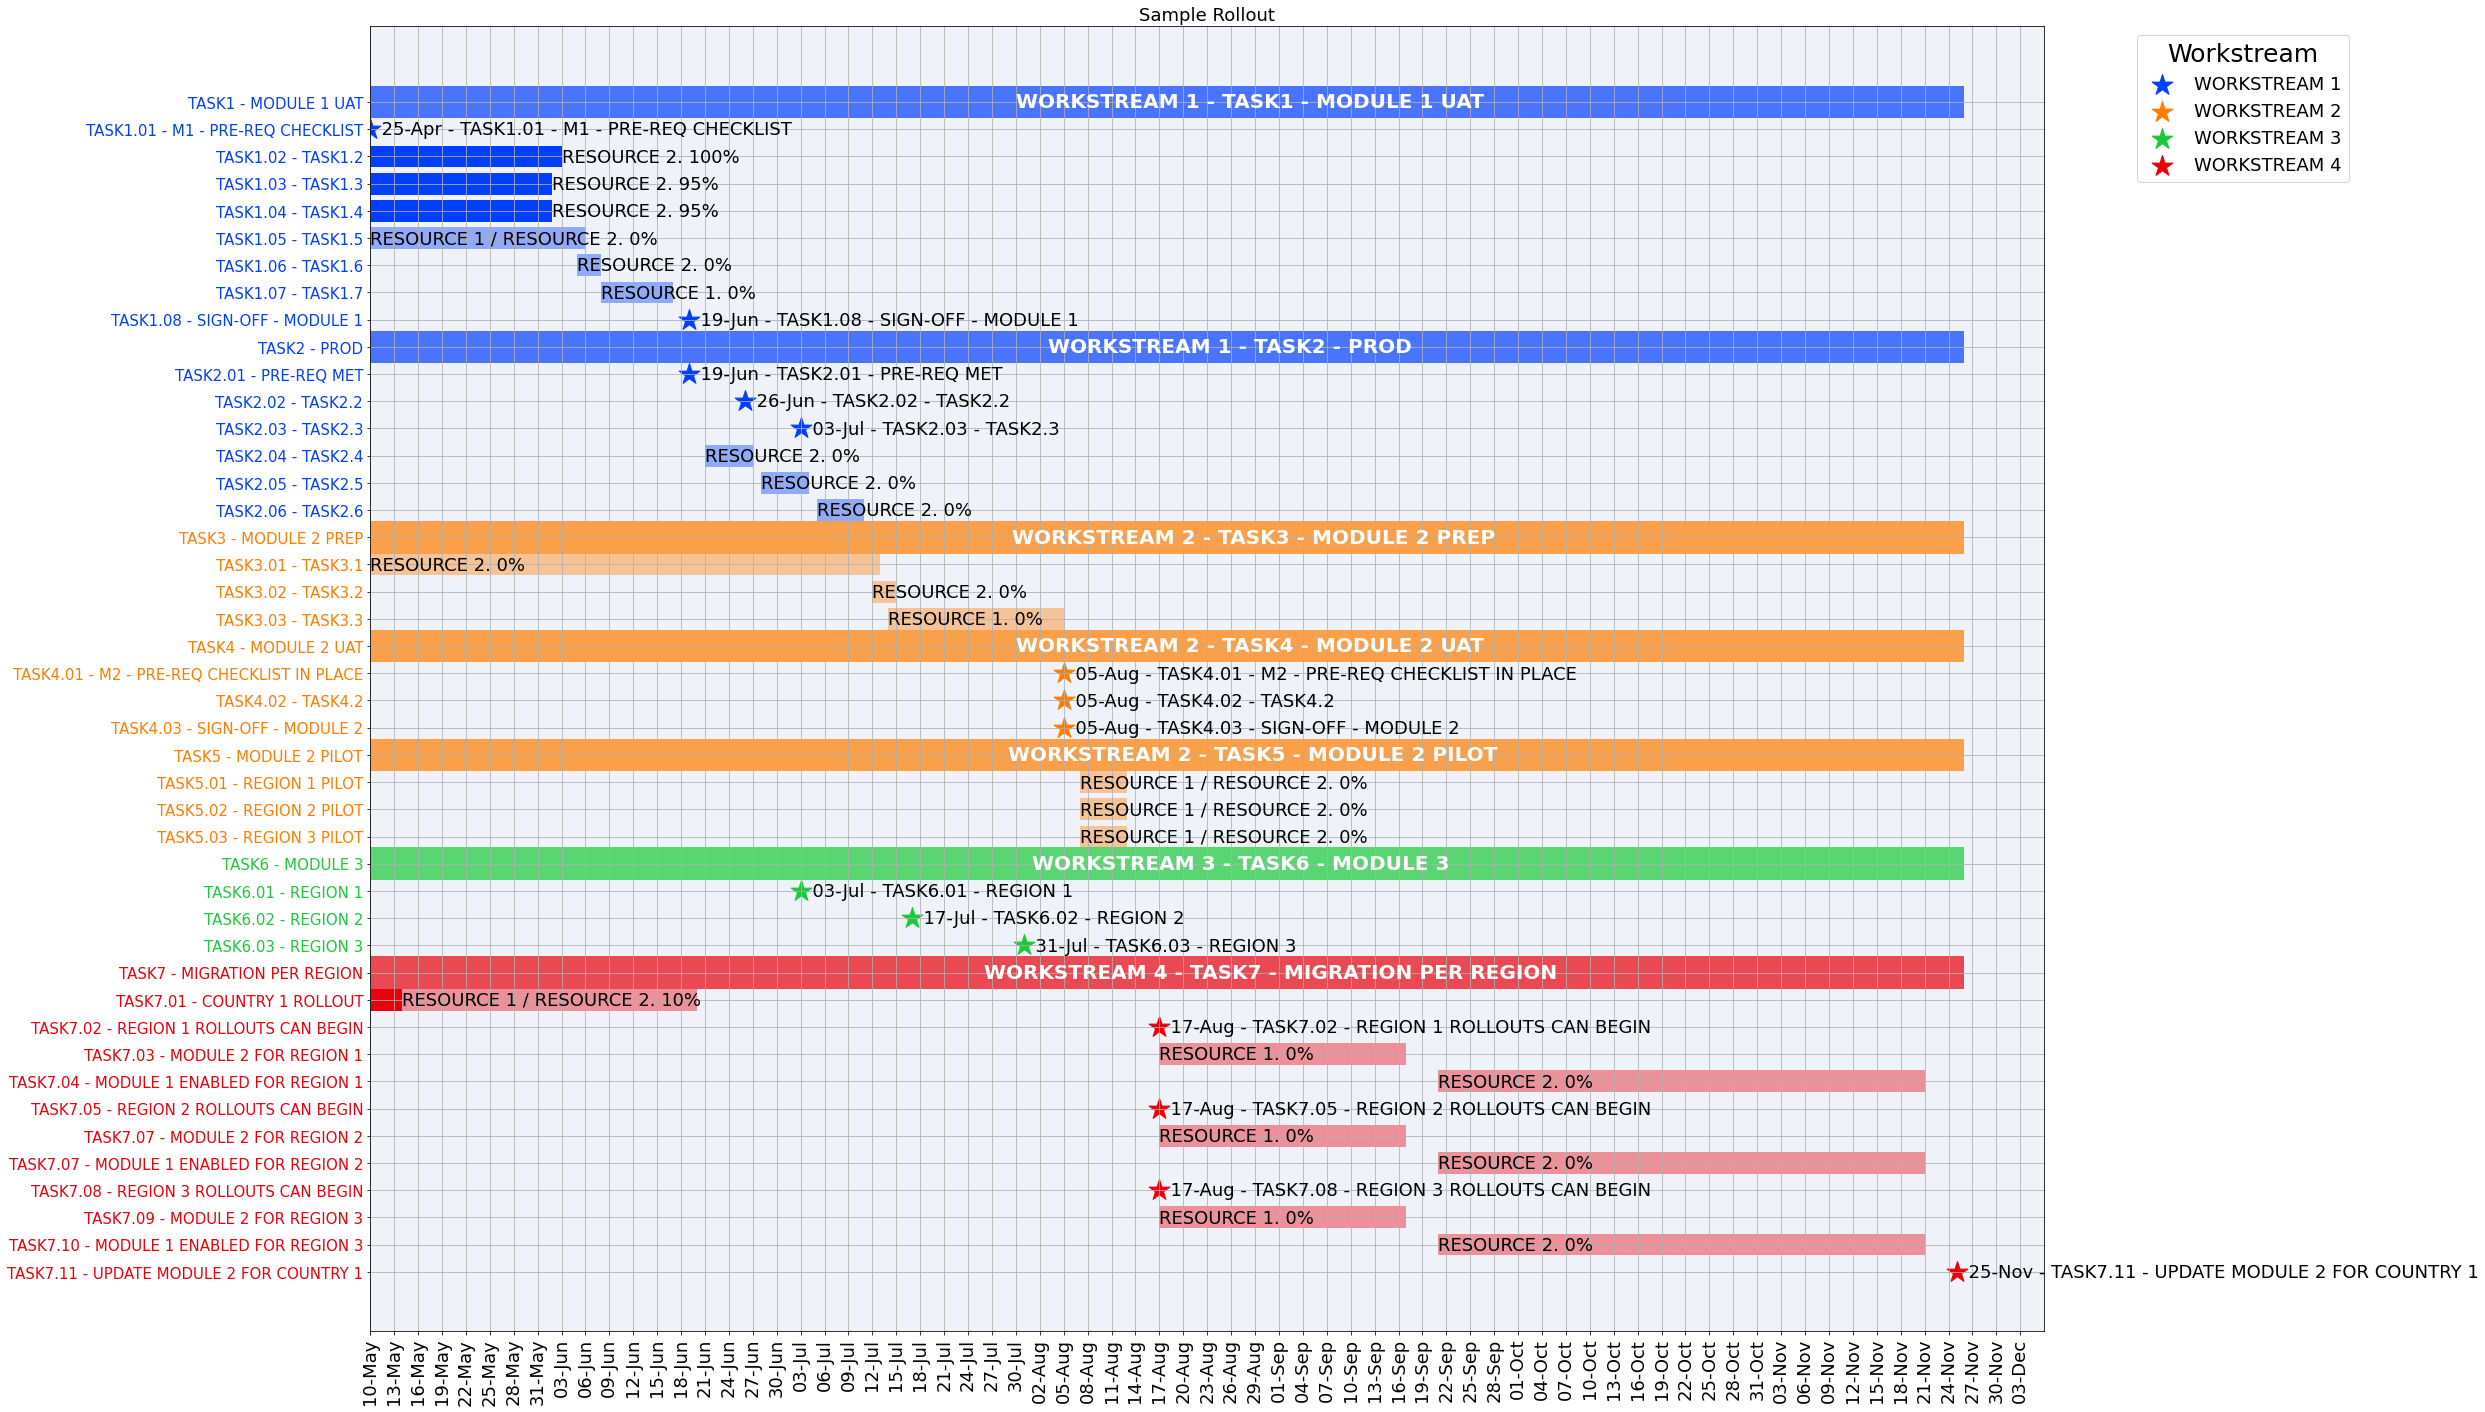

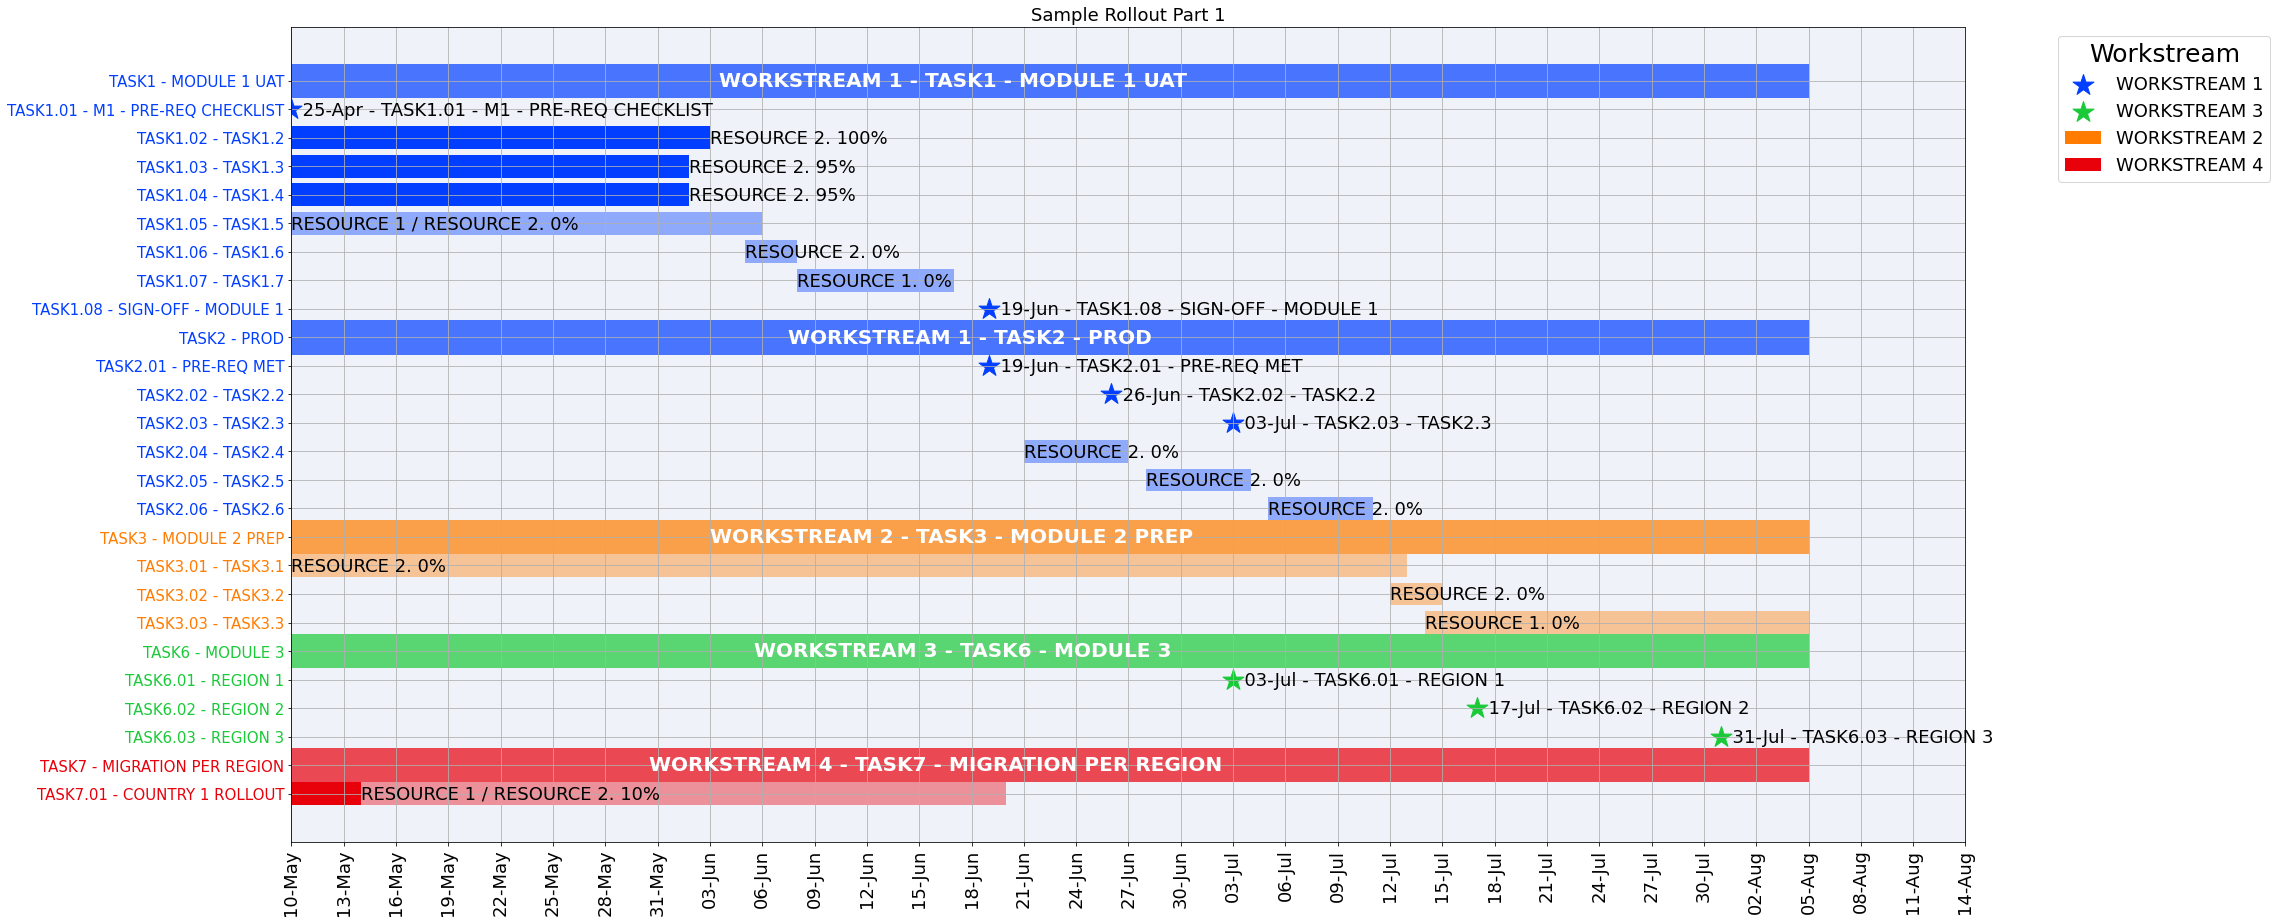

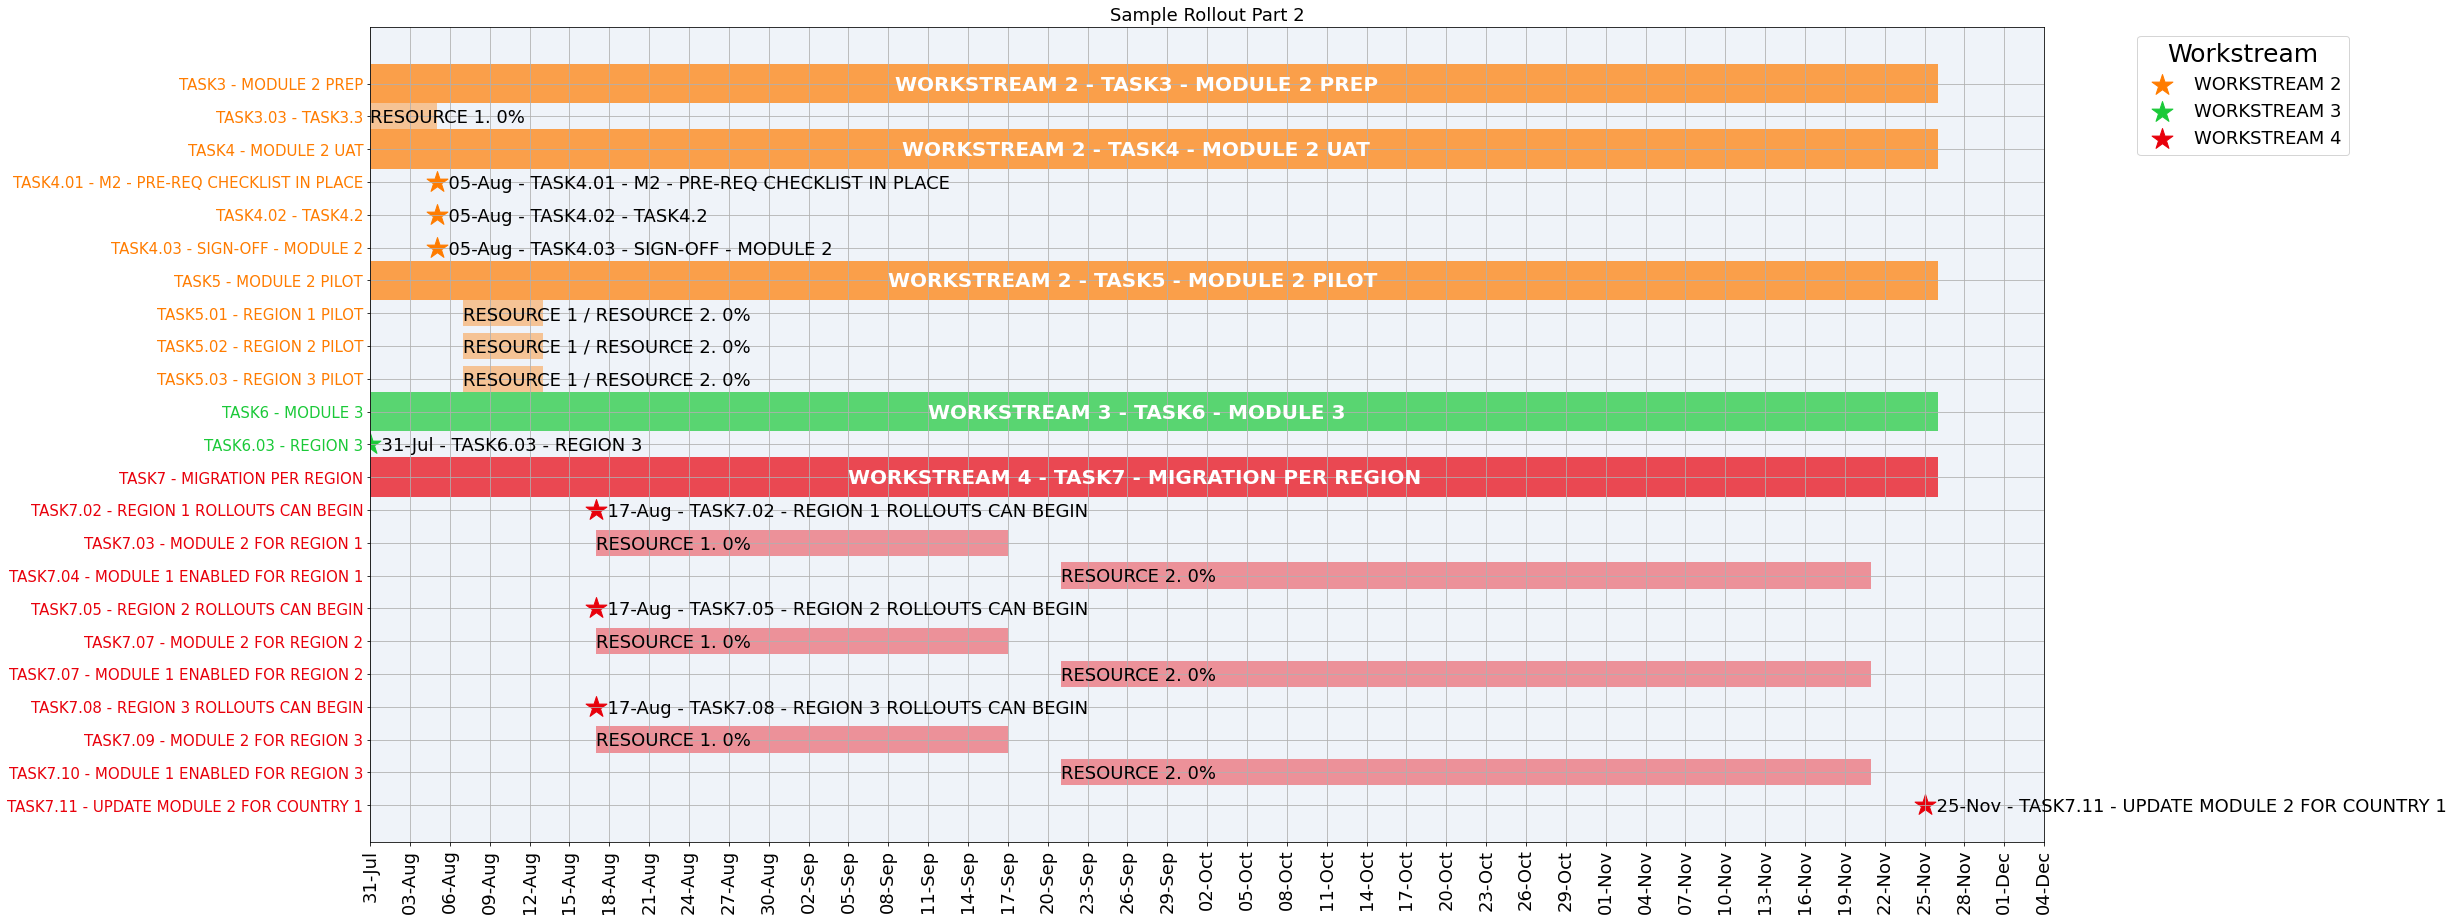

In [8]:
gantt_plot(df, c_dict, 'Sample Rollout')
threshold = 90

df1 = df.loc[(df.rel_Start < threshold) | 
             ((df.Level == 'Top') & (df.Start > (df.End.max() - pd.DateOffset(days=threshold)))) |
             (df.End < df[(df['rel_Start'] < threshold) & (df['Level'] != 'Top')].End.max())
            ].reset_index(drop=True).copy()
gantt_plot(df1, c_dict, 'Sample Rollout Part 1', 0, 30, 15)

df2 = df.loc[(df.rel_Start > threshold) | 
             ((df.Level == 'Top') & (df.End > (df.Start.min() + pd.DateOffset(days=threshold)))) | 
             (df.End > df[(df['rel_Start'] > threshold) & (df['Level'] != 'Top')].Start.min())
            ].reset_index(drop=True).copy()
gantt_plot(df2, c_dict, 'Sample Rollout Part 2',threshold, 30, 15)

# Get HTML Gantt Chart using Plotly Library

In [9]:
import plotly.express as px
import plotly.graph_objects as go
#fig = px.timeline(df, x_start="Start", x_end="End", y="Task", color="Completion", height = 1000)
dia_df = df[df['duration'] == 0]
title = "Sample Rollout"

# Create a mapping of workstreams to colors
color_mapping = c_dict

rect = px.timeline(df, x_start="Start", x_end="End", y="Task", color="Workstream",text = "Task",
                   hover_name="Task", hover_data=["Workstream", "Start", "End", "Resource"])
#rect.update_traces(marker=dict(line=dict(width=1, color='black')))
rect.update_traces(textposition='outside')
rect.update_yaxes(autorange='reversed')
rect.update_layout(title=title, showlegend=True, 
                   height=1500, 
                   #width=1000
                  )
if not dia_df.empty:
    # Add diamond shape for milestones
    dia = px.scatter(dia_df, x="Start", y="Task", 
                     color="Workstream", 
                     symbol_sequence=['star'],
                     hover_name="Task", hover_data=["Workstream", "Start", "Resource"],
                     #text = "Task",
                    #color_discrete_sequence=['orange']
                    )
    
    dia.update_traces(marker=dict(size=10, line=dict(width=1)),
                      #textposition='middle right'
                     )
    dia.update_yaxes(autorange="reversed")

fig = go.Figure(data=rect.data + dia.data, layout=rect.layout)
fig.update_layout(
    bargap=0.5
    ,bargroupgap=0.1
    ,xaxis_range=[df.Start.min(), df.End.max()]
    ,xaxis = dict(
        showgrid=True
        ,rangeslider_visible=True
        ,side ="top"
        ,tickmode = 'array'
        ,dtick="M1"
        ,tickformat="Q%q-%Y \n"
        ,ticklabelmode="period"        
        ,ticks="outside"
        ,tickson="boundaries"
        ,tickwidth=.1
        ,layer='below traces'
        ,ticklen=20
        ,tickfont=dict(
            family='Old Standard TT, serif',size=24,color='grey')
        ,rangeselector=dict(
            buttons=list([
                dict(count=1, label="1m", step="month", stepmode="backward"),
                dict(count=6, label="6m", step="month", stepmode="backward"),
                dict(count=1, label="YTD", step="year", stepmode="todate"),
                dict(count=1, label="1y", step="year", stepmode="backward"),
                dict(step="all")
            ])
            ,x=.37
            ,y=-.05
            ,font=dict(
                family="Arial",
                size=14,
                color="darkgray"
    )))
    
    ,yaxis = dict(
        title= "Activities"
        ,autorange="reversed"
        ,automargin=True
         #,anchor="free"
        ,ticklen=10
        ,showgrid=True
        ,showticklabels=True
        ,tickfont=dict(
            family='Old Standard TT, serif', size=16, color='gray'))
    
    ,legend=dict(
        orientation="h"
        ,yanchor="bottom"
        ,y=1.1
        ,title=""
        ,xanchor="right"
        ,x=1
        ,font=dict(
            #family="Arial",
            size=10
            ,color="darkgray"))
)

fig.show()
fig.write_html("Sample Rollout.html")